$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [2]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [3]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/nevoagmon/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/nevoagmon/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/nevoagmon/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [4]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


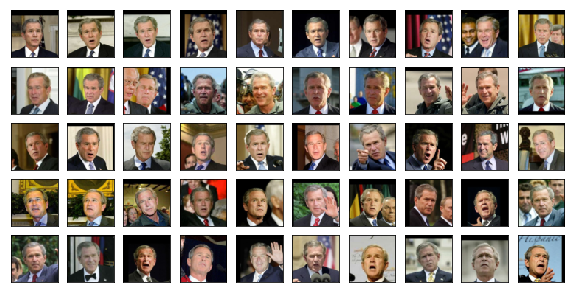

In [5]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [6]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [7]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 250, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=16000, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [31]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 250, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(1000, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Si

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [10]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients.

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

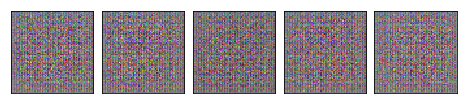

In [11]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [57]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 10, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: 0.6429693652864765
Generator loss:     7.152631899889777


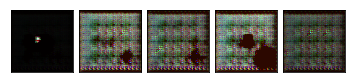

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 1.1279077284476335
Generator loss:     6.100880160051234


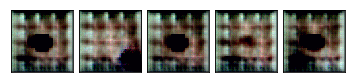

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 1.149587852113387
Generator loss:     4.052209903212154


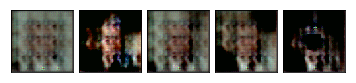

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.6314365495653713
Generator loss:     2.737534298616297


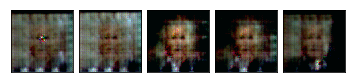

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 0.44448774702408733
Generator loss:     4.112388148027308


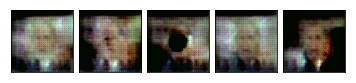

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.90it/s]
Discriminator loss: 0.31292344542110667
Generator loss:     4.673804493511424


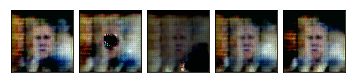

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.048147408401265
Generator loss:     3.6689783615224503


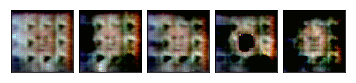

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.3827902551959543
Generator loss:     3.9134428360882927


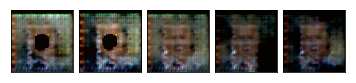

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.4209982060334262
Generator loss:     4.4366773717543655


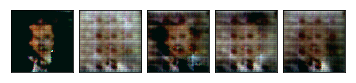

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.6943186030668371
Generator loss:     3.741685656940236


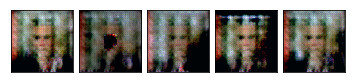

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.8188287072321948
Generator loss:     3.738111783476437


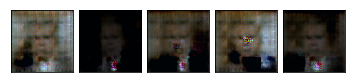

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.5261569768190384
Generator loss:     3.8838668167591095


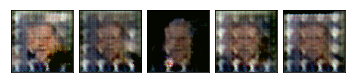

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 1.0280034261591293
Generator loss:     3.271259209688972


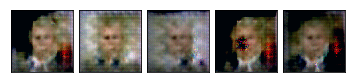

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.7997743925627541
Generator loss:     3.536908374113195


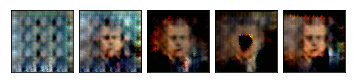

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.8743297597941231
Generator loss:     3.229924566605512


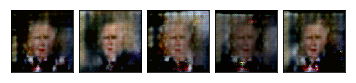

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.8986433130853316
Generator loss:     3.0789449670735527


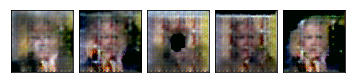

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.90it/s]
Discriminator loss: 0.6708083959186778
Generator loss:     3.5620327837326946


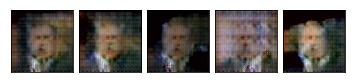

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.55542272679946
Generator loss:     3.6218428822124706


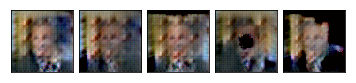

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 1.0900565455941593
Generator loss:     3.155969623257132


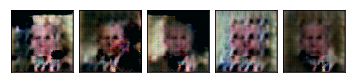

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.6741697805769303
Generator loss:     3.466335822554196


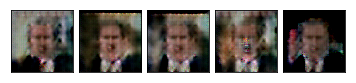

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.042045130449183
Generator loss:     2.6953003424055435


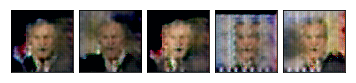

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.7716695561128504
Generator loss:     3.1776481411036324


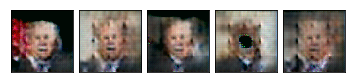

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.85it/s]
Discriminator loss: 0.9586734350989846
Generator loss:     2.7567259003134335


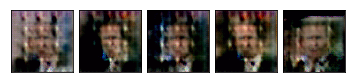

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.90it/s]
Discriminator loss: 0.8427364054848167
Generator loss:     3.086686604163226


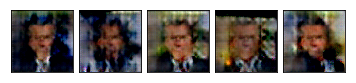

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.85it/s]
Discriminator loss: 0.8760731185183805
Generator loss:     3.3450410646550797


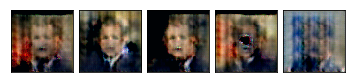

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.8785888938342824
Generator loss:     3.037569414166843


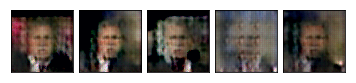

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.9628784253316767
Generator loss:     2.451293682350832


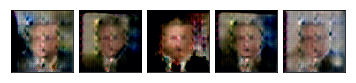

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
Discriminator loss: 1.019276415600496
Generator loss:     2.3465735807138333


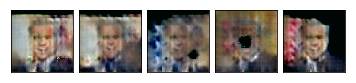

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 0.9531389913138222
Generator loss:     2.6253413803437176


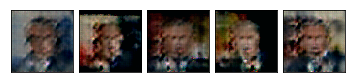

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 1.0157475962358362
Generator loss:     2.161858139669194


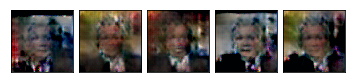

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.7807056220138774
Generator loss:     2.815427576794344


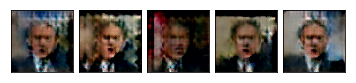

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 1.0692532658576965
Generator loss:     2.5785896830699024


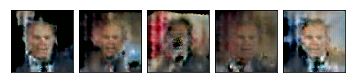

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 1.0597794161123388
Generator loss:     2.1992763999630425


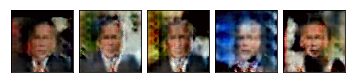

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.9788953381426194
Generator loss:     2.4706613000701454


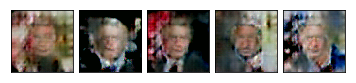

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 1.0351756144972408
Generator loss:     2.1890082937829636


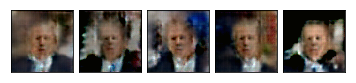

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.84it/s]
Discriminator loss: 0.9825181400074678
Generator loss:     2.297637501183678


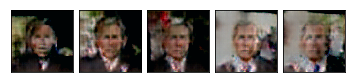

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.8581356897073633
Generator loss:     2.6314883021747364


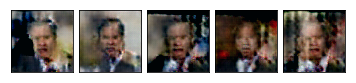

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.8965897910735187
Generator loss:     2.650883625535404


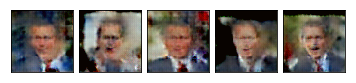

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.9855937326655668
Generator loss:     2.431456586893867


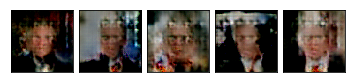

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.8133983506875879
Generator loss:     2.675472897641799


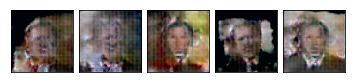

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 1.0717309187440311
Generator loss:     2.2148075699806213


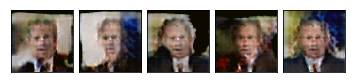

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 1.00506209099994
Generator loss:     2.382066582932192


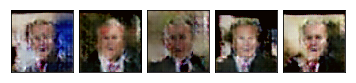

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.9061266148791594
Generator loss:     2.4974488300435684


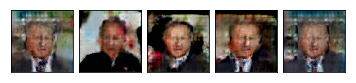

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.8686574346878949
Generator loss:     2.8221396733732784


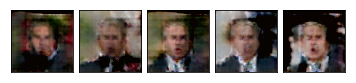

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.9775093092637903
Generator loss:     2.606570047490737


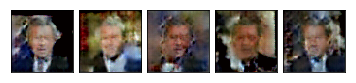

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.9571589441860423
Generator loss:     2.6859100145452164


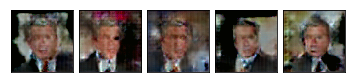

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.98it/s]
Discriminator loss: 0.8417629389201894
Generator loss:     2.7056742976693546


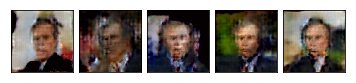

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.7238037147942711
Generator loss:     2.983083451495451


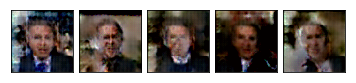

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.9411259538987103
Generator loss:     3.0449262015959797


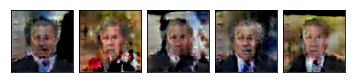

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.8180542886257172
Generator loss:     3.011088441399967


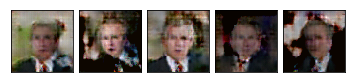

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 0.8471382751184351
Generator loss:     2.8986567048465504


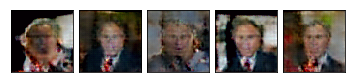

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.7820537651286406
Generator loss:     3.1060519569060383


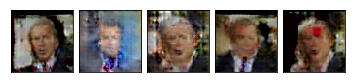

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.7699516766211566
Generator loss:     3.1389779132955216


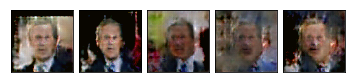

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.8486169979852789
Generator loss:     3.137370404075174


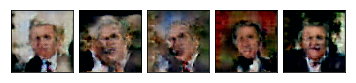

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.00it/s]
Discriminator loss: 0.6681408549056334
Generator loss:     3.320000003365909


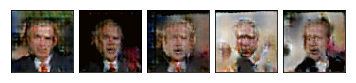

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.698312899645637
Generator loss:     3.3518648831283344


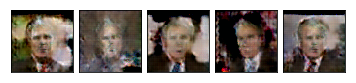

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 1.0867561101913452
Generator loss:     2.8441466093063354


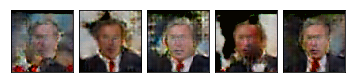

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:06<00:00,  3.02it/s]
Discriminator loss: 0.8884692121954525
Generator loss:     3.0175412682925953


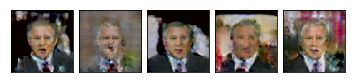

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.97it/s]
Discriminator loss: 0.5969304091790143
Generator loss:     3.2264910024755142


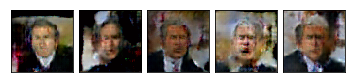

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.85it/s]
Discriminator loss: 0.7342718664337607
Generator loss:     3.602457242853501


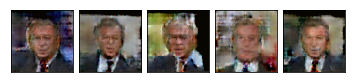

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.7789926493869108
Generator loss:     3.3017596076516544


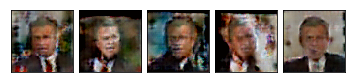

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.7295236517401302
Generator loss:     3.324652489493875


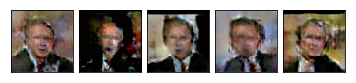

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.5288006417891559
Generator loss:     3.7635633384480194


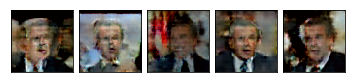

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.6833070499055526
Generator loss:     3.6033018476822796


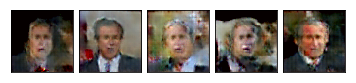

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.6058792349170236
Generator loss:     3.6700223263572243


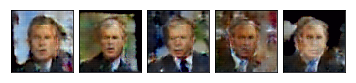

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.7250925714478773
Generator loss:     3.6562275956658756


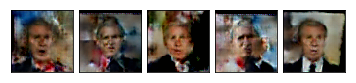

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.6995201180962956
Generator loss:     3.6700789086958943


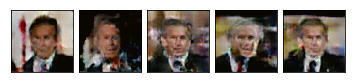

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.85it/s]
Discriminator loss: 0.4788511509404463
Generator loss:     4.084004261914422


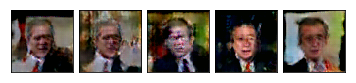

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.84it/s]
Discriminator loss: 0.45396612146321463
Generator loss:     3.9392987840315876


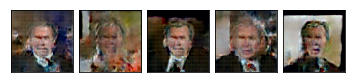

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.7961510419845581
Generator loss:     4.045468042878544


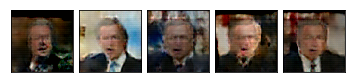

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.7774021923542023
Generator loss:     3.4907390931073357


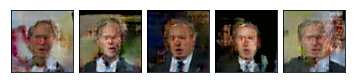

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.5544340321246315
Generator loss:     4.133463866570416


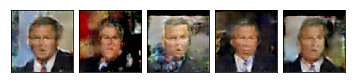

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.96it/s]
Discriminator loss: 0.7337903275209314
Generator loss:     3.6170143169515274


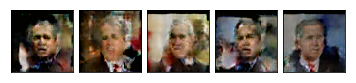

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.6153087703620687
Generator loss:     3.9992057856391456


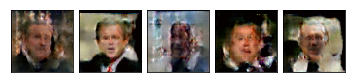

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.90it/s]
Discriminator loss: 0.5721007673179402
Generator loss:     4.09680157549241


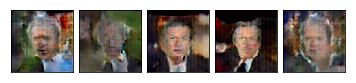

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.41280702983631806
Generator loss:     4.395288691801183


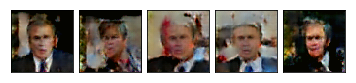

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.90it/s]
Discriminator loss: 0.4556984866366667
Generator loss:     4.6250403067644905


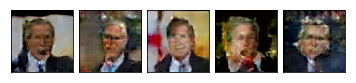

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.5250876011217341
Generator loss:     4.527703397414264


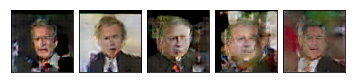

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.712657663752051
Generator loss:     4.126779693014481


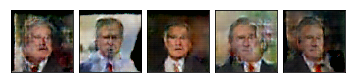

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.89it/s]
Discriminator loss: 0.5055013246396008
Generator loss:     4.214290745118085


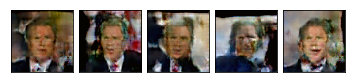

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.4368143607588375
Generator loss:     4.280328890856574


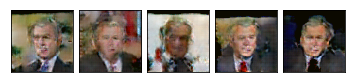

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.3901726410669439
Generator loss:     4.489644541459925


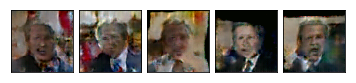

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.5570309547817006
Generator loss:     4.843409419059753


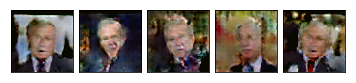

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.5582765971913057
Generator loss:     4.488968218074126


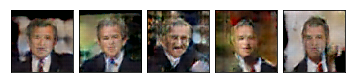

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.6052223461515763
Generator loss:     4.482523805954877


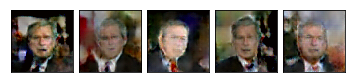

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.44817916347700004
Generator loss:     4.395666038288789


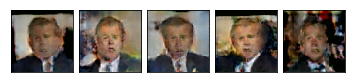

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.95it/s]
Discriminator loss: 0.41032591549789205
Generator loss:     4.619030026828542


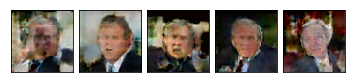

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.94it/s]
Discriminator loss: 0.39996321762309356
Generator loss:     4.804345719954547


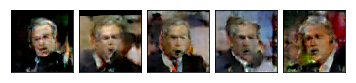

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.87it/s]
Discriminator loss: 0.603129514876534
Generator loss:     4.939912922242108


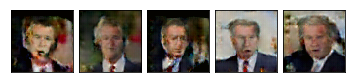

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.5676895380020142
Generator loss:     4.496359180001652


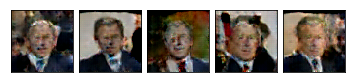

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.91it/s]
Discriminator loss: 0.3394545255338444
Generator loss:     4.61476980938631


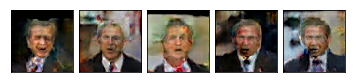

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.88it/s]
Discriminator loss: 0.36849100186544304
Generator loss:     4.787350416183472


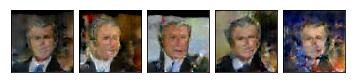

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.93it/s]
Discriminator loss: 0.4371252533267526
Generator loss:     5.095597183003145


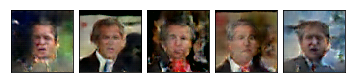

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.84it/s]
Discriminator loss: 0.7409432530403137
Generator loss:     4.271258185891544


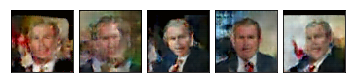

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.4629165582797107
Generator loss:     4.572179261375876


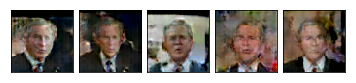

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 0.31437837814583497
Generator loss:     4.778341615901274


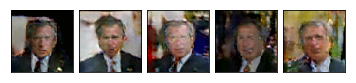

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.86it/s]
Discriminator loss: 0.3229763875989353
Generator loss:     5.088379677604227


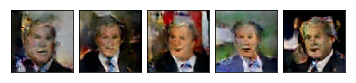

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.25061708622995543
Generator loss:     5.63083675328423


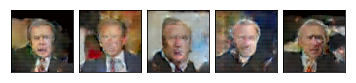

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.92it/s]
Discriminator loss: 0.9091886382769135
Generator loss:     4.938453421873205


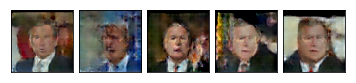

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.99it/s]
Discriminator loss: 0.45473635328166623
Generator loss:     4.318602309507482


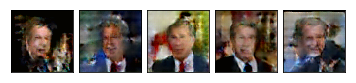

In [59]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


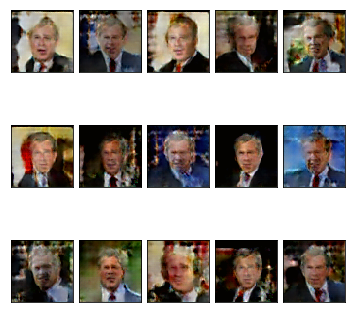

In [60]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [1]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [2]:
display_answer(hw3.answers.part3_q1)


We maintain the gradient when we sample from the generator in the batch training function.
The reason is that when we are training we want the gradient so that we can optimize the result of the generator. In all other occasions we do not maintain the gradient so that we will not change its value and ruine the training.



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [3]:
display_answer(hw3.answers.part3_q2)


We can't decide to stop training based on the generator loss being bellow a certain threshold because the loos of the generator and the loss of the descriminator are connected. We can imagine a situation where the loss of the generator is very low (so we would think to stop training) but in the next batch the descriminator will sudenlly improve and find new differences between the real and fake images therefore the loss of the generator will go back up. If we get into a situation where the loss of the descriminator is constant but the loos of the generator keeps improving then we are in a situation where the descriminator can no longer tell the difference between the real and fake images but the generator keeps making the images better and better in comparison to the real ones.



### Question 2

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [4]:
display_answer(hw3.answers.part3_q3)


The main difference between the results from the VAE and from the GAN is that the with the VAE we get a clear face with almost no background but with good details and with the GAN we get a better overall image in terms of the background and the face in it but with less fine details.
We think that the it is happaning because of the way the models are built, optimized and trained.
The VAE tries to extract the most importent and reoccuring features and convert them to a representation in the latent space, that is why we get a good result for the fine details of the face.
In comparison the GAN tries to optimize the generated image in relation to its ability to distinguish between a real and fake image, therefore it produces images that as a whole look similar to the dataset but the fine details are less importent.

